In [222]:
# more common imports
import pandas as pd
import numpy as np
from collections import Counter
import re

# languange processing imports
import nltk
from gensim.corpora import Dictionary
# preprocessing imports
from sklearn.preprocessing import LabelEncoder

# model imports
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

# visualization imports
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
import io
%matplotlib inline
sns.set()  # defines the style of the plots to be seaborn style
import json
from pprint import pprint


/Users/chiragrastogi/opt/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/chiragrastogi/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [223]:
f = open('messages_w_time.json')
data = json.load(f)
data.keys()

dict_keys(['id', 'text', 'author'])

In [224]:
# create DF from data
train_data = pd.DataFrame.from_dict(data)
data_for_plot = pd.DataFrame.from_dict(data)

In [225]:
train_data

,id,text,author
0,897575377336148008,@everyone Just a quick reminder that our meeti...,UIUC GeoClub
1,897909470028529684,@everyone Just a reminder to that our Kickapoo...,UIUC GeoClub
2,901966694635954236,@everyone we are having some technical diffic...,UIUC GeoClub
3,935259795005509652,@everyone hi everyone! If you haven't heard al...,UIUC GeoClub
4,940631562272268329,@everyone Just a quick reminder that the first...,UIUC GeoClub
...,...,...,...
1941,971904632676818944,u guys good with going at 7 tomorrow? or 6? i’...,loanly
1942,972020510194036807,7 pm tomorrow,loanly
1943,974387641237778502,I got an astronomy test at 8 am tomorrow man,loanly
1944,974771470377037944,I'm just planning to leave before 3 PM tomorrow,loanly


In [226]:
size_list = train_data.groupby(train_data['author'].tolist(),as_index=False).size()['size']
train_data.groupby(train_data['author'].tolist(),as_index=False).size()

,index,size
0,ACM@UIUC,150
1,AHS _ Masters of Public Health,7
2,Actually Neurodivergent,9
3,Archery Club!,34
4,August Productions,10
...,...,...
68,University of Illinois Astronomical Society,8
69,VR Club at UIUC,54
70,WiCyS Illinois,66
71,i need friends,2


In [227]:
train_data = train_data[train_data.author != "loanly"]
train_data = train_data[train_data.author != "i need friends"]
size_list = train_data.groupby(train_data['author'].tolist(),as_index=False).size()['size']

In [228]:
# for i in size_list:
#     print(i)
size_list

0     150
1       7
2       9
3      34
4      10
     ... 
66     93
67     54
68      8
69     54
70     66
Name: size, Length: 71, dtype: int64

In [229]:
train_data['text'] = train_data['author']+" "+train_data['text']
train_data

,id,text,author
0,897575377336148008,UIUC GeoClub @everyone Just a quick reminder t...,UIUC GeoClub
1,897909470028529684,UIUC GeoClub @everyone Just a reminder to that...,UIUC GeoClub
2,901966694635954236,UIUC GeoClub @everyone we are having some tec...,UIUC GeoClub
3,935259795005509652,UIUC GeoClub @everyone hi everyone! If you hav...,UIUC GeoClub
4,940631562272268329,UIUC GeoClub @everyone Just a quick reminder t...,UIUC GeoClub
...,...,...,...
1910,756027361065042000,FAR GANG My pc is night mode after 6,FAR GANG
1911,756027476940947538,FAR GANG > If im not up by 9 am I feel like a ...,FAR GANG
1912,761455581826514984,FAR GANG kinda wanna kms cuz i got done with a...,FAR GANG
1913,765413675741216779,FAR GANG I have it at 8 tomorrow,FAR GANG


In [230]:
train_data['text'].iloc[1]

'UIUC GeoClub @everyone Just a reminder to that our Kickapoo Hiking Trip is this Saturday from 9:30-2! Signup sheet and more info can be found in the following link!'

In [231]:
document_lengths = np.array(list(map(len, train_data.text.str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 76.10350235232619.
The minimum number of words in a document is: 5.
The maximum number of words in a document is: 779.


/Users/chiragrastogi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


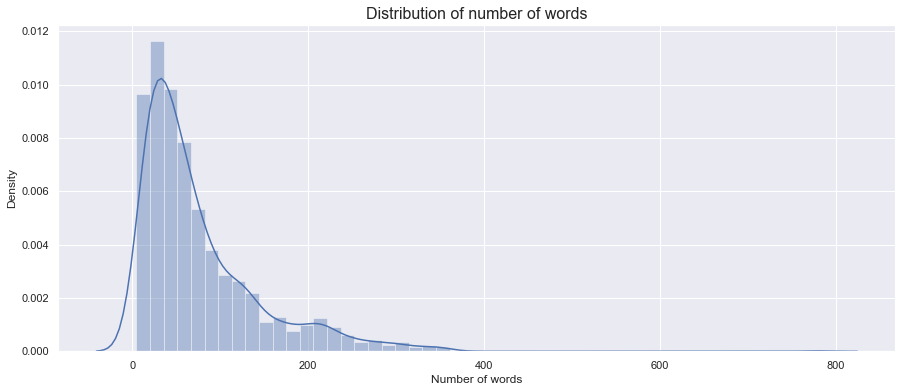

In [232]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(document_lengths, bins=50, ax=ax);

In [233]:
print("There are {} documents with over 300 words.".format(sum(document_lengths > 300)))

shorter_documents = document_lengths[document_lengths <= 300]

There are 26 documents with over 300 words.


/Users/chiragrastogi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


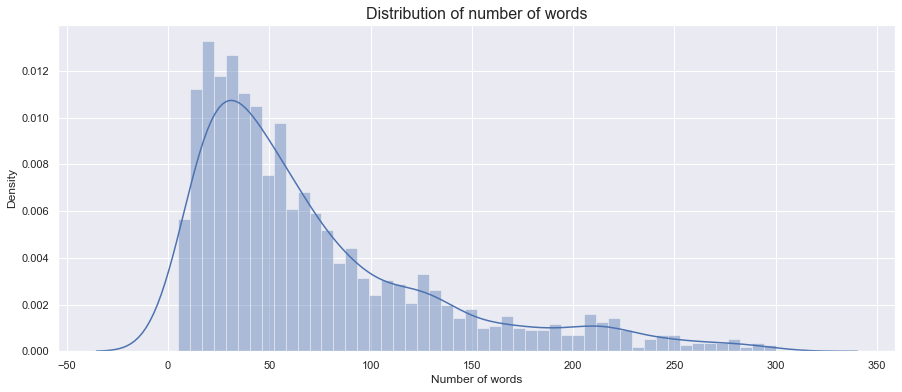

In [234]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(shorter_documents, bins=50, ax=ax);

In [235]:
print("There are {} documents with tops 5 words.".format(sum(document_lengths <= 5)))

There are 7 documents with tops 5 words.


In [236]:
train_data[document_lengths == 5]

,id,text,author
337,883568807497584670,UIUC osu! 1 pm tomorrow,UIUC osu!
1220,867450343389659136,Illini Chess 4pm good today?,Illini Chess
1230,883426453172133898,Illini Chess sunday at 3,Illini Chess
1232,886407663750090762,Illini Chess tomorrow at 3,Illini Chess
1561,887453178692509787,SIGecom Meeting at 5pm today,SIGecom
1906,747994234979876875,FAR GANG ...1:30 hours later,FAR GANG
1907,748353973031010325,FAR GANG tomorrow at 5:00,FAR GANG


In [237]:
train_data

,id,text,author
0,897575377336148008,UIUC GeoClub @everyone Just a quick reminder t...,UIUC GeoClub
1,897909470028529684,UIUC GeoClub @everyone Just a reminder to that...,UIUC GeoClub
2,901966694635954236,UIUC GeoClub @everyone we are having some tec...,UIUC GeoClub
3,935259795005509652,UIUC GeoClub @everyone hi everyone! If you hav...,UIUC GeoClub
4,940631562272268329,UIUC GeoClub @everyone Just a quick reminder t...,UIUC GeoClub
...,...,...,...
1910,756027361065042000,FAR GANG My pc is night mode after 6,FAR GANG
1911,756027476940947538,FAR GANG > If im not up by 9 am I feel like a ...,FAR GANG
1912,761455581826514984,FAR GANG kinda wanna kms cuz i got done with a...,FAR GANG
1913,765413675741216779,FAR GANG I have it at 8 tomorrow,FAR GANG


In [238]:
train_data.iloc[1902]['text']

'FAR GANG @everyone Juice, candy and pics in the lobby until 7PM today courtsey of the FAR council.'

In [239]:
train_data.loc[1901, 'text']

'Cosplay Design League @everyone Saturday we will be having another meeting at 3:30. Same time and place. We are gonna finish up the mask making this week for those who did not finish last week!'

In [240]:
train_data.iloc[1903]

id                                       746847261753081946
text      FAR GANG Meeting at 5:00 today to just walk an...
author                                             FAR GANG
Name: 1905, dtype: object

In [241]:
train_data = train_data.reset_index(drop=True)

In [242]:
def remove_ascii_words(df):
    """ removes non-ascii characters from the 'texts' column in df.
    It returns the words containig non-ascii characers.
    """
    non_ascii_words = []
    for i in range(len(df)):
#         print(i)
#         print("text:::    ##",df.loc[i, 'text'])
        for word in df.loc[i, 'text'].split(' '):
            if any([ord(character) >= 128 for character in word]):
                non_ascii_words.append(word)
                df.loc[i, 'text'] = df.loc[i, 'text'].replace(word, "#")
    return non_ascii_words

non_ascii_words = remove_ascii_words(train_data)

print("Replaced {} words with characters with an ordinal >= 128 in the train data.".format(
    len(non_ascii_words)))

Replaced 1479 words with characters with an ordinal >= 128 in the train data.


In [243]:
def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

In [244]:
def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['text'] = df.text.str.lower()
    df['document_sentences'] = df.text.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(get_good_tokens, sentences)),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists

w2v_preprocessing(train_data)

In [245]:
def lda_get_good_tokens(df):
    df['text'] = df.text.str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.text))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))

lda_get_good_tokens(train_data)

In [246]:
tokenized_only_dict = Counter(np.concatenate(train_data.tokenized_text.values))

tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
tokenized_only_df.rename(columns={0: 'count'}, inplace=True)

In [247]:
tokenized_only_df.sort_values('count', ascending=False, inplace=True)

/Users/chiragrastogi/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


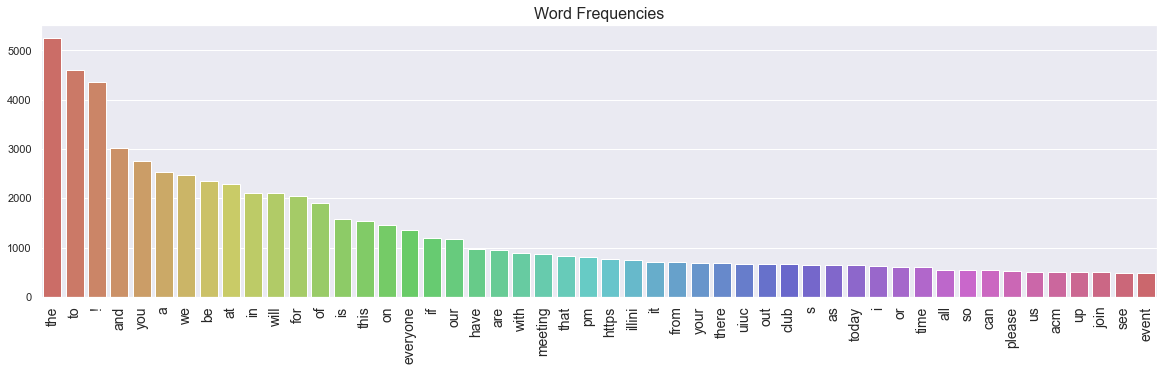

In [248]:
def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot(tokenized_only_df)
ax.set_title("Word Frequencies", fontsize=16);

In [249]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chiragrastogi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [250]:
# nltk.download('stopwords')
our_special_word = '#'
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    # Luckily nltk already has a set of stopwords that we can remove from the texts.
    stopwords = nltk.corpus.stopwords.words('english')
    # we'll add our own special word in here 'qwerty'
    stopwords.append(our_special_word)

    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))

remove_stopwords(train_data)

In [251]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chiragrastogi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [252]:
# nltk.download('wordnet')
nltk.download('omw-1.4')
def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))

stem_words(train_data)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/chiragrastogi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [253]:
dictionary = Dictionary(documents=train_data.stemmed_text.values)

print("Found {} words.".format(len(dictionary.values())))

Found 7153 words.


In [254]:
dictionary.filter_extremes(no_above=0.8, no_below=2)

dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Left with 3819 words.


In [255]:
#Make a BOW for every document
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    
document_to_bow(train_data)

In [256]:
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    stem_words(df)
    document_to_bow(df)

In [257]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

In [258]:
cleansed_words_df.sort_values('count', ascending=False, inplace=True)

/Users/chiragrastogi/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


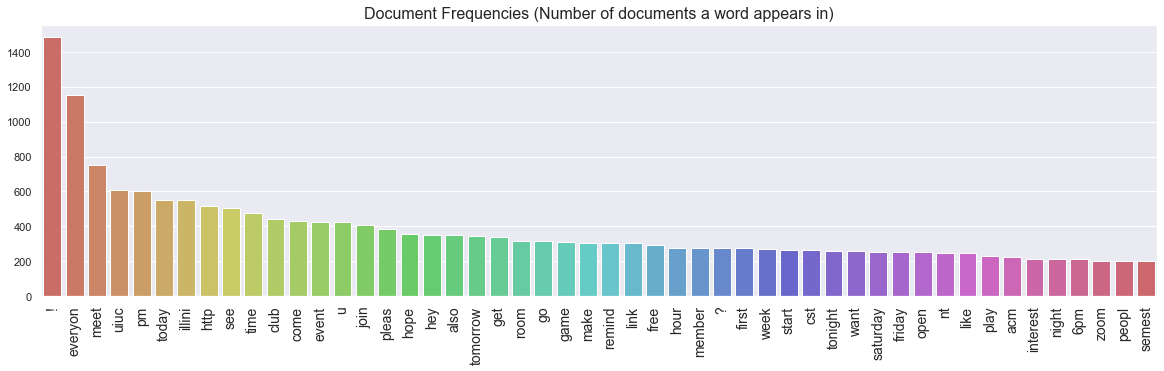

In [259]:
ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16);

In [260]:
train_data

,id,text,author,document_sentences,tokenized_sentences,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow
0,897575377336148008,uiuc geoclub @everyone just a quick reminder t...,UIUC GeoClub,[uiuc geoclub @everyone just a quick reminder ...,"[[uiuc, geoclub, everyone, just, a, quick, rem...","[uiuc, geoclub, everyone, just, a, quick, remi...","[uiuc, geoclub, everyone, quick, reminder, mee...","[uiuc, geoclub, everyone, quick, reminder, mee...","[uiuc, geoclub, everyon, quick, remind, meet, ...","[(0, 3), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1..."
1,897909470028529684,uiuc geoclub @everyone just a reminder to that...,UIUC GeoClub,[uiuc geoclub @everyone just a reminder to tha...,"[[uiuc, geoclub, everyone, just, a, reminder, ...","[uiuc, geoclub, everyone, just, a, reminder, t...","[uiuc, geoclub, everyone, reminder, kickapoo, ...","[uiuc, geoclub, everyone, reminder, kickapoo, ...","[uiuc, geoclub, everyon, remind, kickapoo, hik...","[(0, 2), (6, 1), (9, 1), (15, 1), (20, 1), (22..."
2,901966694635954236,uiuc geoclub @everyone we are having some tec...,UIUC GeoClub,[uiuc geoclub @everyone we are having some te...,"[[uiuc, geoclub, everyone, we, are, having, so...","[uiuc, geoclub, everyone, we, are, having, som...","[uiuc, geoclub, everyone, technical, difficult...","[uiuc, geoclub, everyone, technical, difficult...","[uiuc, geoclub, everyon, technic, difficulti, ...","[(0, 15), (2, 1), (6, 1), (9, 4), (11, 1), (12..."
3,935259795005509652,uiuc geoclub @everyone hi everyone! if you hav...,UIUC GeoClub,[uiuc geoclub @everyone hi everyone! if you ha...,"[[uiuc, geoclub, everyone, hi, everyone, !, if...","[uiuc, geoclub, everyone, hi, everyone, !, if,...","[uiuc, geoclub, everyone, hi, everyone, !, nt,...","[uiuc, geoclub, everyone, hi, everyone, !, nt,...","[uiuc, geoclub, everyon, hi, everyon, !, nt, h...","[(0, 3), (3, 1), (6, 2), (9, 1), (19, 1), (20,..."
4,940631562272268329,uiuc geoclub @everyone just a quick reminder t...,UIUC GeoClub,[uiuc geoclub @everyone just a quick reminder ...,"[[uiuc, geoclub, everyone, just, a, quick, rem...","[uiuc, geoclub, everyone, just, a, quick, remi...","[uiuc, geoclub, everyone, quick, reminder, fir...","[uiuc, geoclub, everyone, quick, reminder, fir...","[uiuc, geoclub, everyon, quick, remind, first,...","[(0, 1), (4, 1), (6, 1), (9, 2), (11, 1), (14,..."
...,...,...,...,...,...,...,...,...,...,...
1908,756027361065042000,far gang my pc is night mode after 6,FAR GANG,[far gang my pc is night mode after 6],"[[far, gang, my, pc, is, night, mode, after, 6]]","[far, gang, my, pc, is, night, mode, after, 6]","[far, gang, pc, night, mode, 6]","[far, gang, pc, night, mode, 6]","[far, gang, pc, night, mode, 6]","[(185, 1), (292, 1), (298, 1), (871, 1), (1682..."
1909,756027476940947538,far gang > if im not up by 9 am i feel like a ...,FAR GANG,[far gang > if im not up by 9 am i feel like a...,"[[far, gang, if, im, not, up, by, 9, am, i, fe...","[far, gang, if, im, not, up, by, 9, am, i, fee...","[far, gang, im, 9, feel, like, pos, system, po...","[far, gang, im, 9, feel, like, po, system, po,...","[far, gang, im, 9, feel, like, po, system, po,...","[(7, 1), (161, 1), (178, 1), (254, 1), (305, 1..."
1910,761455581826514984,far gang kinda wanna kms cuz i got done with a...,FAR GANG,[far gang kinda wanna kms cuz i got done with ...,"[[far, gang, kinda, wan, na, kms, cuz, i, got,...","[far, gang, kinda, wan, na, kms, cuz, i, got, ...","[far, gang, kinda, wan, na, kms, cuz, got, don...","[far, gang, kinda, wan, na, km, cuz, got, done...","[far, gang, kinda, wan, na, km, cuz, got, done...","[(134, 1), (356, 1), (471, 1), (869, 1), (871,..."
1911,765413675741216779,far gang i have it at 8 tomorrow,FAR GANG,[far gang i have it at 8 tomorrow],"[[far, gang, i, have, it, at, 8, tomorrow]]","[far, gang, i, have, it, at, 8, tomorrow]","[far, gang, 8, tomorrow]","[far, gang, 8, tomorrow]","[far, gang, 8, tomorrow]","[(198, 1), (345, 1), (871, 1), (2903, 1)]"


In [261]:
corpus = train_data.bow

In [262]:
corpus

0       [(0, 3), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1...
1       [(0, 2), (6, 1), (9, 1), (15, 1), (20, 1), (22...
2       [(0, 15), (2, 1), (6, 1), (9, 4), (11, 1), (12...
3       [(0, 3), (3, 1), (6, 2), (9, 1), (19, 1), (20,...
4       [(0, 1), (4, 1), (6, 1), (9, 2), (11, 1), (14,...
                              ...                        
1908    [(185, 1), (292, 1), (298, 1), (871, 1), (1682...
1909    [(7, 1), (161, 1), (178, 1), (254, 1), (305, 1...
1910    [(134, 1), (356, 1), (471, 1), (869, 1), (871,...
1911            [(198, 1), (345, 1), (871, 1), (2903, 1)]
1912    [(0, 3), (13, 1), (20, 1), (21, 1), (49, 1), (...
Name: bow, Length: 1913, dtype: object

In [263]:
%%time
num_topics = 7
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

CPU times: user 4.8 s, sys: 388 ms, total: 5.19 s
Wall time: 11.6 s


In [264]:
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

train_data['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      train_data.bow))


In [265]:
train_data

,id,text,author,document_sentences,tokenized_sentences,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow,lda_features
0,897575377336148008,uiuc geoclub @everyone just a quick reminder t...,UIUC GeoClub,[uiuc geoclub @everyone just a quick reminder ...,"[[uiuc, geoclub, everyone, just, a, quick, rem...","[uiuc, geoclub, everyone, just, a, quick, remi...","[uiuc, geoclub, everyone, quick, reminder, mee...","[uiuc, geoclub, everyone, quick, reminder, mee...","[uiuc, geoclub, everyon, quick, remind, meet, ...","[(0, 3), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1...","[0.18499329686164856, 0.667880654335022, 0.005..."
1,897909470028529684,uiuc geoclub @everyone just a reminder to that...,UIUC GeoClub,[uiuc geoclub @everyone just a reminder to tha...,"[[uiuc, geoclub, everyone, just, a, reminder, ...","[uiuc, geoclub, everyone, just, a, reminder, t...","[uiuc, geoclub, everyone, reminder, kickapoo, ...","[uiuc, geoclub, everyone, reminder, kickapoo, ...","[uiuc, geoclub, everyon, remind, kickapoo, hik...","[(0, 2), (6, 1), (9, 1), (15, 1), (20, 1), (22...","[0.017608683556318283, 0.01214886736124754, 0...."
2,901966694635954236,uiuc geoclub @everyone we are having some tec...,UIUC GeoClub,[uiuc geoclub @everyone we are having some te...,"[[uiuc, geoclub, everyone, we, are, having, so...","[uiuc, geoclub, everyone, we, are, having, som...","[uiuc, geoclub, everyone, technical, difficult...","[uiuc, geoclub, everyone, technical, difficult...","[uiuc, geoclub, everyon, technic, difficulti, ...","[(0, 15), (2, 1), (6, 1), (9, 4), (11, 1), (12...","[0.20881730318069458, 0.0018900468712672591, 0..."
3,935259795005509652,uiuc geoclub @everyone hi everyone! if you hav...,UIUC GeoClub,[uiuc geoclub @everyone hi everyone! if you ha...,"[[uiuc, geoclub, everyone, hi, everyone, !, if...","[uiuc, geoclub, everyone, hi, everyone, !, if,...","[uiuc, geoclub, everyone, hi, everyone, !, nt,...","[uiuc, geoclub, everyone, hi, everyone, !, nt,...","[uiuc, geoclub, everyon, hi, everyon, !, nt, h...","[(0, 3), (3, 1), (6, 2), (9, 1), (19, 1), (20,...","[0.2028016448020935, 0.005095512140542269, 0.1..."
4,940631562272268329,uiuc geoclub @everyone just a quick reminder t...,UIUC GeoClub,[uiuc geoclub @everyone just a quick reminder ...,"[[uiuc, geoclub, everyone, just, a, quick, rem...","[uiuc, geoclub, everyone, just, a, quick, remi...","[uiuc, geoclub, everyone, quick, reminder, fir...","[uiuc, geoclub, everyone, quick, reminder, fir...","[uiuc, geoclub, everyon, quick, remind, first,...","[(0, 1), (4, 1), (6, 1), (9, 2), (11, 1), (14,...","[0.017154578119516373, 0.011499770916998386, 0..."
...,...,...,...,...,...,...,...,...,...,...,...
1908,756027361065042000,far gang my pc is night mode after 6,FAR GANG,[far gang my pc is night mode after 6],"[[far, gang, my, pc, is, night, mode, after, 6]]","[far, gang, my, pc, is, night, mode, after, 6]","[far, gang, pc, night, mode, 6]","[far, gang, pc, night, mode, 6]","[far, gang, pc, night, mode, 6]","[(185, 1), (292, 1), (298, 1), (871, 1), (1682...","[0.420763224363327, 0.5009559392929077, 0.0213..."
1909,756027476940947538,far gang > if im not up by 9 am i feel like a ...,FAR GANG,[far gang > if im not up by 9 am i feel like a...,"[[far, gang, if, im, not, up, by, 9, am, i, fe...","[far, gang, if, im, not, up, by, 9, am, i, fee...","[far, gang, im, 9, feel, like, pos, system, po...","[far, gang, im, 9, feel, like, po, system, po,...","[far, gang, im, 9, feel, like, po, system, po,...","[(7, 1), (161, 1), (178, 1), (254, 1), (305, 1...","[0.932503342628479, 0.01764793135225773, 0.013..."
1910,761455581826514984,far gang kinda wanna kms cuz i got done with a...,FAR GANG,[far gang kinda wanna kms cuz i got done with ...,"[[far, gang, kinda, wan, na, kms, cuz, i, got,...","[far, gang, kinda, wan, na, kms, cuz, i, got, ...","[far, gang, kinda, wan, na, kms, cuz, got, don...","[far, gang, kinda, wan, na, km, cuz, got, done...","[far, gang, kinda, wan, na, km, cuz, got, done...","[(134, 1), (356, 1), (47

In [266]:
# Print the Keyword in the 10 topics
pprint(LDAmodel.print_topics())
doc_lda = LDAmodel[corpus]

[(0,
  '0.030*"!" + 0.020*"meet" + 0.018*"everyon" + 0.018*"club" + 0.016*"illini" '
  '+ 0.012*"pm" + 0.012*"chess" + 0.010*"time" + 0.009*"today" + 0.009*"room"'),
 (1,
  '0.059*"!" + 0.021*"game" + 0.017*"everyon" + 0.012*"come" + 0.011*"night" + '
  '0.011*"event" + 0.011*"acm" + 0.009*"http" + 0.009*"join" + 0.008*"cst"'),
 (2,
  '0.029*"!" + 0.017*"today" + 0.017*"everyon" + 0.012*"meet" + 0.012*"acm" + '
  '0.011*"http" + 0.010*"time" + 0.009*"join" + 0.009*"gamebuild" + '
  '0.009*"member"'),
 (3,
  '0.060*"!" + 0.018*"meet" + 0.015*"vr" + 0.011*"event" + 0.011*"everyon" + '
  '0.010*"http" + 0.009*"u" + 0.009*"open" + 0.009*"pm" + 0.008*"club"'),
 (4,
  '0.065*"!" + 0.023*"http" + 0.016*"everyon" + 0.012*"esport" + '
  '0.010*"illini" + 0.010*"join" + 0.009*"acm" + 0.009*"event" + 0.009*"link" '
  '+ 0.007*"today"'),
 (5,
  '0.066*"!" + 0.021*"uiuc" + 0.017*"pm" + 0.013*"everyon" + 0.011*"smash" + '
  '0.010*"acm" + 0.008*"see" + 0.008*"lobbi" + 0.008*"commun" + 0.008*"event"'

In [267]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(LDAmodel, corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

/Users/chiragrastogi/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/chiragrastogi/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/chiragrastogi/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/chiragrastogi/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/ch

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.024643 -0.020375       1        1  25.217520
1     -0.056959  0.023896       2        1  19.581153
3     -0.002436  0.007100       3        1  16.967910
5     -0.018713  0.076869       4        1  11.671265
4     -0.057069  0.057417       5        1  11.253997
6      0.157160 -0.000789       6        1   9.468267
2     -0.046626 -0.144117       7        1   5.839889, topic_info=       Term         Freq        Total Category  logprob  loglift
0         !  4215.000000  4215.000000  Default  30.0000  30.0000
2631     vr   247.000000   247.000000  Default  29.0000  29.0000
388     acm   482.000000   482.000000  Default  28.0000  28.0000
258    http   760.000000   760.000000  Default  27.0000  27.0000
11     meet  1125.000000  1125.000000  Default  26.0000  26.0000
...     ...          ...          ...      ...      ...      ...
82        u    32.341669   514.800346   Topic7  -5.0497   0.0730
93    event    34.035458   651.663663   Topic7  -4.9987  -0.1117
290       ?    28.617670   354.182946   Topic7  -5.1721   0.3247
26     link    27.319783   349.053668   Topic7  -5.2185   0.2928
292   night    25.066984   271.368817   Topic7  -5.3045   0.4585

[581 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         1  0.153704     !
0         2  0.237198     !
0         3  0.208497     !
0         4  0.158448     !
0         5  0.149435     !
...     ...       ...   ...
420       3  0.288227  zoom
420       4  0.003948  zoom
420       5  0.086863  zoom
420       6  0.098708  zoom
420       7  0.047380  zoom

[1460 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 6, 5, 7, 3])

# Use for topic modeling

In [268]:
# train_data

In [270]:
#topic 6 = recreation
for index,row in train_data.iterrows():
#     print(row['document_sentences'])
    print()
    sentence = row['stemmed_text']
    new_text_corpus =  dictionary.doc2bow(sentence)
    predictions = LDAmodel[new_text_corpus]
    max_tuple = max(predictions, key=lambda tup: tup[1])
    if max_tuple[0]+1 == 3:
        print(row['text'])
        print("topic",max_tuple[0]+1)






uiuc geoclub @everyone just a quick reminder that the first meeting of geoclub for this semester is today at 6pm in the core of the natural history building!
topic 3






























































































sigpwny @ uiuctf @everyone on thursday march 31, 2022 from 6:00-7:00pm in siebel 1404, uiuc's technology services cybersecurity team will be joining sigpwny to tell war stories, answer questions about their line of work, and discuss career pathways in cybersecurity! everyone is welcome to join and ask questions in advance using this form: https://forms.gle/xjra3k1f5ixiqcm99


topic 3








































































uiuc smash ultimate community server @uiuc folks 

__**the welcome week tournament will be this wednesday, august 26th!**__ 

the tournament is hosted by a third party company called bravous esports that we are working with through the illini union. 
it will be broadcasted on


















































acm@uiuc hey @everyone! make sure to join the icebreaker event tonight at 8pm central. # be a great opportunity to meet new people and make friends before school even starts! the link to join can be found here: https://gatheround.com/events/aj1wv0arzxkt0faazb7g. please let me know if you have any questions and i look forward to seeing you all there #
topic 3






















acm@uiuc hey guys! make sure to join us for happy hour at legends at 4:30pm today. there is no age requirement and plenty of free food.
topic 3



acm@uiuc hey guys! just a reminder that there will be our regular happy hour today at legends @ 4:30pm.
topic 3



acm@uiuc hey everyone! just a reminder that **happy hour is happening today at 4:30pm at legends**. see you soon!
topic 3


acm@uiuc hey @everyone! i hope you had a great break. we will be hosting our*** final happy hour of the semester this friday*** at 4:30pm at legends. also make sure to ***come to the
































































































































ddrillini the penn state crew once departed for [one of the rip events] by leaving state college at 5:30pm on friday.  the driver had a late friday class and couldn't skip.  that was not an enjoyable tournament experience (too much driving, too much sleep deprivation).

leave early on friday if at all possible.
topic 3







































illini chess @everyone the bughouse tournament will be at 6 pm today, you can join at this link here: https://www.chess.com/live#t=1554541
you must be a part of the chess.com club in order to participate
topic 3

illini chess @everyone we're having a lichess tournament today at 7pm central time. here's the link to join if you're interested: https://lichess.org/tournament/qrvdnexg
topic 3

illini chess @everyone we're having a lichess tournament in a few minutes today at 6pm central time. here's the link to j














open @everyone 
hi # be hosting our very first git workshop this saturday (sept. 12th) at 12:30pm ct! git is a version control system widely used in the open-source community, and learning it is crucial to making contributions. # be going over the basics of git, covering topics like making repositories, making commits,  publishing to github, and making prs. if you # installed git already, please make sure # installed it by 12:30pm ct so that you can dive right into learning. # upload an installation instructions video for windows into the discord #deleted-channel channel, but if you decide install git on your own, # also put some things that you should be mindful of when configuring your install. note: linux and macos should already have git installed (or configurable), but if not, send us a message in the discord.

# be active on discord in case you guys run into any trouble or need any clarification, and # open the video call 30 minutes before the workshop start time in 

In [145]:
text=pd.DataFrame({'text':['@everyone just a quick reminder that our meeting today is at 5:30pm in the core of nhb! the theme is rocks and socks so if you have some cool rocks and crazy socks to show then please bring them! feel free to bring rocks that you want identified too!']})




In [133]:
new_text_corpus =  dictionary.doc2bow(text['text'][0].split())
# new_text_corpus

In [134]:
predictions = LDAmodel[new_text_corpus]
max_tuple = max(predictions, key=lambda tup: tup[1])
predictions

[(0, 0.012309222), (2, 0.23200649), (3, 0.38758138), (4, 0.3399522)]

In [129]:
print("topic",max_tuple[0]+1)

topic 4


In [126]:
train_data.iloc[0]['text']

'@everyone just a quick reminder that our meeting today is at 5:30pm in the core of nhb! the theme is rocks and socks so if you have some cool rocks and crazy socks to show then please bring them! feel free to bring rocks that you want identified too!'